In [173]:
import math
import random
import torch
import matplotlib.pyplot as plt
from scipy.spatial import distance
import itertools
import jellyfish
import numpy as np
import os, shutil

In [174]:
# import the words I'm using
%run partial_words.py
%run core.py
%run imgCls.py

In [49]:
def delete_files_dir(folder):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [53]:
delete_files_dir("./alternate_training")

In [163]:
class DeepSpellingChecker:
    #ky_dct = load_keys(dr_lc)
    def __init__(self,encode_dir,net_dir):
        self.encode_dir = encode_dir
        self.net_dir = net_dir
        self.ky_dct = load_keys(encode_dir)
        self.mapp = None
        return
    def encode_image(self,wrd):
        return encode_word(wrd,self.ky_dct)
    def create_word_mistake(self,wrd):
        return word_mix(wrd)
    def can_use_gpu(self):
        return torch.cuda.is_available()
    def train_words(self,wrd_list):
        rt_name = "mdl_spelling"
        dcMapping = {}
        maxDepth = 30
        wrl = WordManage()
        wrl.set_words(wrd_list,0)
        # clean out the network directory
        delete_files_dir(self.net_dir)
        # 
        train_and_choose(rt_name,wrl,dcMapping,maxDepth,self.net_dir)
        
        file_path = self.mapping_file()
        
        save_json(dcMapping,file_path)
        
        self.mapp = dcMapping
        return 
    
    def mapping_file(self):
        return  os.path.join(self.net_dir, "word_tree_mapping.json")
    
    def best_word_match(self,wrd,dbg=False):
        
        file_path = self.mapping_file()
        
        if self.mapp == None:
            self.mapp = load_json(file_path)
                
        rt_name = "mdl_spelling"
        
        wd  = spell_word(wrd,rt_name,self.mapp,self.net_dir, dbg)
        
        if len(wd) > 1:
            srt = sorted(wd,key=lambda ky : jellyfish.damerau_levenshtein_distance(wrd,ky))
            print("matches... ",srt)
            return srt[0]
        else:
            return wd[0]


In [22]:
def show_image(img):
    plt.figure(figsize=(10,2))
    #plt.imshow(img,aspect="auto",extent=(0,5,1e0,1e5),interpolation='nearest')
    plt.imshow(img,aspect="auto",interpolation='nearest')
    plt.show()
    return

In [164]:
deep_sp = DeepSpellingChecker("","./alternate_training")

In [60]:
deep_sp.can_use_gpu()

True

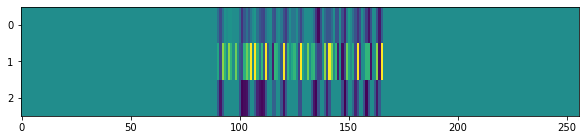

In [40]:
show_image(deep_sp.encode_image("This is a phrase encoded for demo to get a rough idea of what they look like"))

In [41]:
for i in range(10):
    print(deep_sp.create_word_mistake("conditional"))

conditional
conditimnal
coenidtional
conditional
conditional
conditio al
codnitional
conditiohnal
condig ional
jonditional


In [172]:
word_to_train = ["cat","dog","fish","shark","lark","child","log","chicken","ostrich","zebra","fox","kitten","saint bernard","salmon","cobra","rattlesnake"]
deep_sp.train_words(sbst)

train tree..
category  0  total word count  0
category  1  total word count  0
category  2  total word count  1525
recursing on  mdl_spelling_2  total words..  1525
train tree..
category  0  total word count  402
recursing on  mdl_spelling_2_0  total words..  402
train tree..
category  0  total word count  0
category  1  total word count  0
category  2  total word count  324
recursing on  mdl_spelling_2_0_2  total words..  324
train tree..
category  0  total word count  0
category  1  total word count  0
category  2  total word count  0
category  3  total word count  324
recursing on  mdl_spelling_2_0_2_3  total words..  324
train tree..
category  0  total word count  62
recursing on  mdl_spelling_2_0_2_3_0  total words..  62
train tree..
category  0  total word count  0
category  1  total word count  0
category  2  total word count  3
recursing on  mdl_spelling_2_0_2_3_0_2  total words..  3
Words.. ['study', 'stuff', 'rough']
train tree..
not seperating for words ..  ['study', 'stuff'

KeyboardInterrupt: 

In [165]:
arr = deep_sp.best_word_match("kitten")

In [167]:
arr

'kitten'

In [147]:
for d in arr:
    print(jellyfish.damerau_levenshtein_distance("c4t",d))

1
3
3
3


In [ ]:
def test_words(wrds):
    wrl = WordManage()
    wrl.set_words(wrds,0)
    mdl = build_choose_and_train(wrl,dbg=True,out_cat=5)
    wrds = wrl.all_words()
    cats = get_category(mdl,wrds,dbg=True)
    print("categories... ",cats)
    return

In [ ]:
im = ImgNet(5)
im.apply(custom_init_weights)
im = best_move(im)
get_category(im,['Chris','Schrumm','Programmer','Test','Nice','Some','Zero','Whatever','Mouse','Other'])

In [ ]:
ww = word_batch(['Chris','Schrumm'])

In [ ]:
def display_im(im):
    plt.figure(figsize=(25, 150),dpi=80)
    plt.imshow(im)

In [ ]:
display_im(ww[0][0])

In [ ]:
tt = numpy_to_tensor(np.array([3,4,5]))
tt.to(best_device())
tensor_info(tt)

In [ ]:
word_batch(["chris","schrumm"]).shape

In [ ]:
wrl = WordManage()
wrl.set_words(sbst,0)
ntwrk_name = "mdl_spelling"
dr = "./net_data"
fl = dr + "/" + ntwrk_name + ".bin"
mdl = best_move(ImgNet(5))
load_file_into_model(mdl,fl)
all_wrds = wrl.all_words()
cat_w = get_category(mdl,all_wrds)
out_cat = 5

In [ ]:
build_choose_and_train(wrl,dbg=True)

In [ ]:
cat_list = [[all_wrds[v] for v,ct in enumerate(cat_w) if ct == i ] for i in range(out_cat)]

In [ ]:
targ_arr = []
in_arr = []

for _ in range(15):
    for i in range(out_cat):
        #print("lenght list ",len(cat_list[i]))
        lst = random.sample(cat_list[i], k=min(len(cat_list[i]),15))
        #print(len(lst))
    
        for w in lst:
            targ_arr.append(i)
            wd = word_mix(w)
            wrd = encode_word(wd)
            wrd = np.expand_dims(wrd,axis=0)
            in_arr.append(wrd)
            
tn_in, tn_trg  = np.stack(in_arr),np.array(targ_arr,dtype=np.long)


In [ ]:
l = tn_trg.shape[0]

In [ ]:
l

In [ ]:
def train_loop(epoch,tn_in,tn_arg, model, optimizer, scheduler,dbg):   
    
    example_size = tn_arg.shape[0]
    example_indexes = [x for x in range(example_size)]
    for i in range(epoch):
        for b in batch(example_indexes,256):
            #print(b[0],b[-1])
            
            optimizer.zero_grad()
            
            data = tn_in[b[0]:b[-1]]
            target = tn_arg[b[0]:b[-1]]
            
            #print("training data ",data.shape)
            
            data = numpy_to_tensor(data)
            target = numpy_to_tensor(target)
            
            output = model(data)
            
            loss = F.nll_loss(output,target)
            loss.backward()
            
            optimizer.step()
            
        scheduler.step()
        if dbg:
            print("lr.. ",scheduler.get_lr())

In [ ]:
'''
def build_choose_and_train(wrl,dbg=False,out_cat=5):
    out_num = 5
    targ_arr = []
    in_arr = []
    wrds = choose_spread_combo(out_num, wrl)
    
    for en,v in enumerate(wrds):
        targ_arr.append(en)
        wrd = encode_word(v)
        wrd = np.expand_dims(wrd,axis=0)
        in_arr.append(wrd)
        if dbg:
            print("word ",v," category ",en)
      
    
    for i in range(1000):
        for en,v in enumerate(wrds):
            targ_arr.append(en)
            wd = word_mix(v)
            #if dbg:
            #    print("word ",v," mix ",wd," category ",en)
            wrd = encode_word(wd)
            wrd = np.expand_dims(wrd,axis=0)
            in_arr.append(wrd)
                        
            
    if dbg:
        print("length of input.. ",len(in_arr))
        
    tn_in, tn_trg  = np.stack(in_arr),np.array(targ_arr,dtype=np.long)
    
    epoch = 6
    
    # example_size = len(targ_arr)
    # example_indexes = [x for x in range(example_size)]
    
    model, optimizer, scheduler = build_net_opt_schedule(out_cat)
    
    train_loop(epoch,tn_in,tn_trg, model, optimizer, scheduler,dbg)
    
    
    if dbg:
        print("second half training..")
    
    # choose category based on the partially trained model..
    
    all_wrds = wrl.all_words()
    cat_w = get_category(model,all_wrds)
    
    #for i,ct in enumerate(cat_w):
    cat_list = [[all_wrds[v] for v,ct in enumerate(cat_w) if ct == i ] for i in range(out_cat)]
    
    in_arr = []
    targ_arr = []
    
    epoch = 40
    
    for _ in range(30):
        for i in range(out_cat):
            #print("lenght list ",len(cat_list[i]))
            lst = random.sample(cat_list[i], k=min(len(cat_list[i]),15))
            #print(len(lst))
    
            for w in lst:
                targ_arr.append(i)
                wd = word_mix(w)
                wrd = encode_word(wd)
                wrd = np.expand_dims(wrd,axis=0)
                in_arr.append(wrd)
            
    tn_in, tn_trg  = np.stack(in_arr),np.array(targ_arr,dtype=np.long)
    
    train_loop(epoch,tn_in,tn_trg, model, optimizer, scheduler,dbg)
    
    if dbg:
        model.eval()
        with torch.no_grad():
            example_size = tn_trg.shape[0]
            example_indexes = [x for x in range(example_size)]
            
            for b in batch(example_indexes,256):
                data = tn_in[b[0]:b[-1]]
                target = tn_trg[b[0]:b[-1]]
                
                data = numpy_to_tensor(data)
                target = numpy_to_tensor(target)
                output = model(data)
                
                # test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
                pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
                correct = pred.eq(target.view_as(pred)).sum().item()
                
                print("correct on batch.. ", (100.0 * correct) / len(b))
    return model
'''

In [128]:
data_ky = load_json("word_tree_mapping.json")

In [ ]:
ntwrk_name = "mdl_spelling"
wrd = "marketing"
dr = "./net_data"

mdl = best_move(ImgNet(5))
       
fl = dr + "/" + ntwrk_name + ".bin"
    
nt = torch.load(fl)

mdl.load_state_dict(nt)
mdl.eval()
      
cats = get_category(mdl,[wrd])

In [ ]:
cats

In [ ]:
mmp = data_ky
sb_ntwrk = ntwrk_name + "_" +  str(cats[0])

word = [k for k,v in mmp.items() if v == sb_ntwrk]

In [ ]:
sb_ntwrk

In [140]:
# pell_word(wrd,ntwrk_name,mmp,dr, dbg=False):     
spell_word("dibate","mdl_spelling",data_ky,"./net_data",dbg=True)

category..  [0]
traverse down..  ./net_data/mdl_spelling_0.bin
category..  [1]
traverse down..  ./net_data/mdl_spelling_0_1.bin
category..  [4]
traverse down..  ./net_data/mdl_spelling_0_1_4.bin
category..  [2]
traverse down..  ./net_data/mdl_spelling_0_1_4_2.bin
category..  [4]
traverse down..  ./net_data/mdl_spelling_0_1_4_2_4.bin
category..  [0]
key  debate  value  mdl_spelling_0_1_4_2_4_0


['debate']

In [ ]:
rt_name = "mdl_spelling"
dcMapping = {}
maxDepth = 30
btch_size = 128
wrl = WordManage()
wrl.set_words(sbst,0)
train_and_choose(rt_name,wrl,dcMapping,maxDepth,btch_size)
save_json(dcMapping,"word_tree_mapping.json")

In [ ]:
wrl.word_count()

In [131]:
vl = "nice"
wrl = WordManage()
wrl.set_words(["cat","dog","fish","shark","lark","child","log","chicken","ostrich","zebra","fox","kitten","saint bernard","salmon","cobra","rattlesnake"],0)

In [132]:
rtTreeName = "mdl_spelling"
avWords = wrl
wdDic = {}

In [135]:
mdl = build_choose_and_train(avWords,True)

word  fish  category  0
word  fox  category  1
word  rattlesnake  category  2
word  log  category  3
word  saint bernard  category  4
length of input..  1255
lr..  [0.768]
lr..  [0.73728]
lr..  [0.7077887999999999]
lr..  [0.679477248]
second half training..
input shape..  (1360, 1, 3, 256)
lr..  [0.6522981580799999]
lr..  [0.6262062317567999]
lr..  [0.6011579824865279]
lr..  [0.5771116631870667]
input shape..  (1360, 1, 3, 256)
lr..  [0.5540271966595841]
lr..  [0.5318661087932006]
lr..  [0.5105914644414726]
lr..  [0.4901678058638137]
input shape..  (1360, 1, 3, 256)
lr..  [0.4705610936292612]
lr..  [0.4517386498840907]
lr..  [0.43366910388872704]
lr..  [0.41632233973317795]
correct on batch..  81.640625
correct on batch..  88.28125
correct on batch..  88.671875
correct on batch..  87.5
correct on batch..  83.203125
correct on batch..  90.0


In [ ]:
wdDic

In [ ]:
save_network(mdl,"test")

In [ ]:
mdl = best_move(ImgNet(5))
load_data_into(mdl,"test")
#mdl = load_network("test")

In [ ]:
wrl.set_category('bike',2)
wrl.set_category('cause',2)
wrl.set_category('clerk',2)

In [ ]:
l = wrl.filter_list(2)

In [ ]:
# ['tension', 'session']
wd_e = encode_word("food")

In [ ]:
def display_im(im):
    plt.figure(figsize=(25, 150),dpi=80)
    plt.imshow(im)